In [26]:
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account
from google.cloud import bigquery as bq
import os
import requests
import json
import glob
import datetime
from datetime import datetime
import pandas as pd
import folium
import random as rnd
from matplotlib import pyplot as plt
from numpy import unique
from itertools import permutations

from IPython.display import Image




def get_coords(events):
    res = []
    for p in events:
        longitude = None
        latitude = None
        for e in p["event_params"]:
            if e["key"] == "longitude": longitude = e["value"]["double_value"]
            if e["key"] == "latitude": latitude = e["value"]["double_value"]
        if longitude != None and latitude != None:
            res.append((latitude,longitude))
    return res

def get_coord(event):
    res = None
    longitude = None
    latitude = None
    for e in event["event_params"]:
        if e["key"] == "longitude": longitude = e["value"]["double_value"]
        if e["key"] == "latitude": latitude = e["value"]["double_value"]
    if longitude != None and latitude != None:
        res = (latitude,longitude)
    return res


def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))


def get_session_id(event):
    for x in event["event_params"]:
        if x["key"] == "ga_session_id":
            return x["value"]["int_value"]
    return "No session id"


def get_ordered_subset(alist):
    subset = []
    for i in range(0,len(alist)):
        for j in range(i+1,len(alist)):
            subset.append(alist[i:j+1])
    return subset 

def list_to_key(alist):
    res = ""
    for x in alist:
       res = res + str(x) + "-->"
    return res[:-3]

def get_most_common_sequence(seq_len, adict):
    maxnum = 0
    res = None
    for k,v in adict.items():
        if len(k.split("-->")) != seq_len:
            continue
        if v>maxnum:
            res = k
            maxnum = v
    return res,maxnum


def get_most_common_sequences(top, min_seq_len, adict):
    maxnumlist = []
    res = []
    for k,v in adict.items(): 
        if len(k.split("-->")) < min_seq_len:
            continue
        if len(maxnumlist) < top:
            maxnumlist.append(v)
            res.append(k)
        else:
            if v > min(maxnumlist):
                index = maxnumlist.index(min(maxnumlist))
                maxnumlist[index] = v
                res[index] = k
    return maxnumlist, res



# Front-end Data Flow

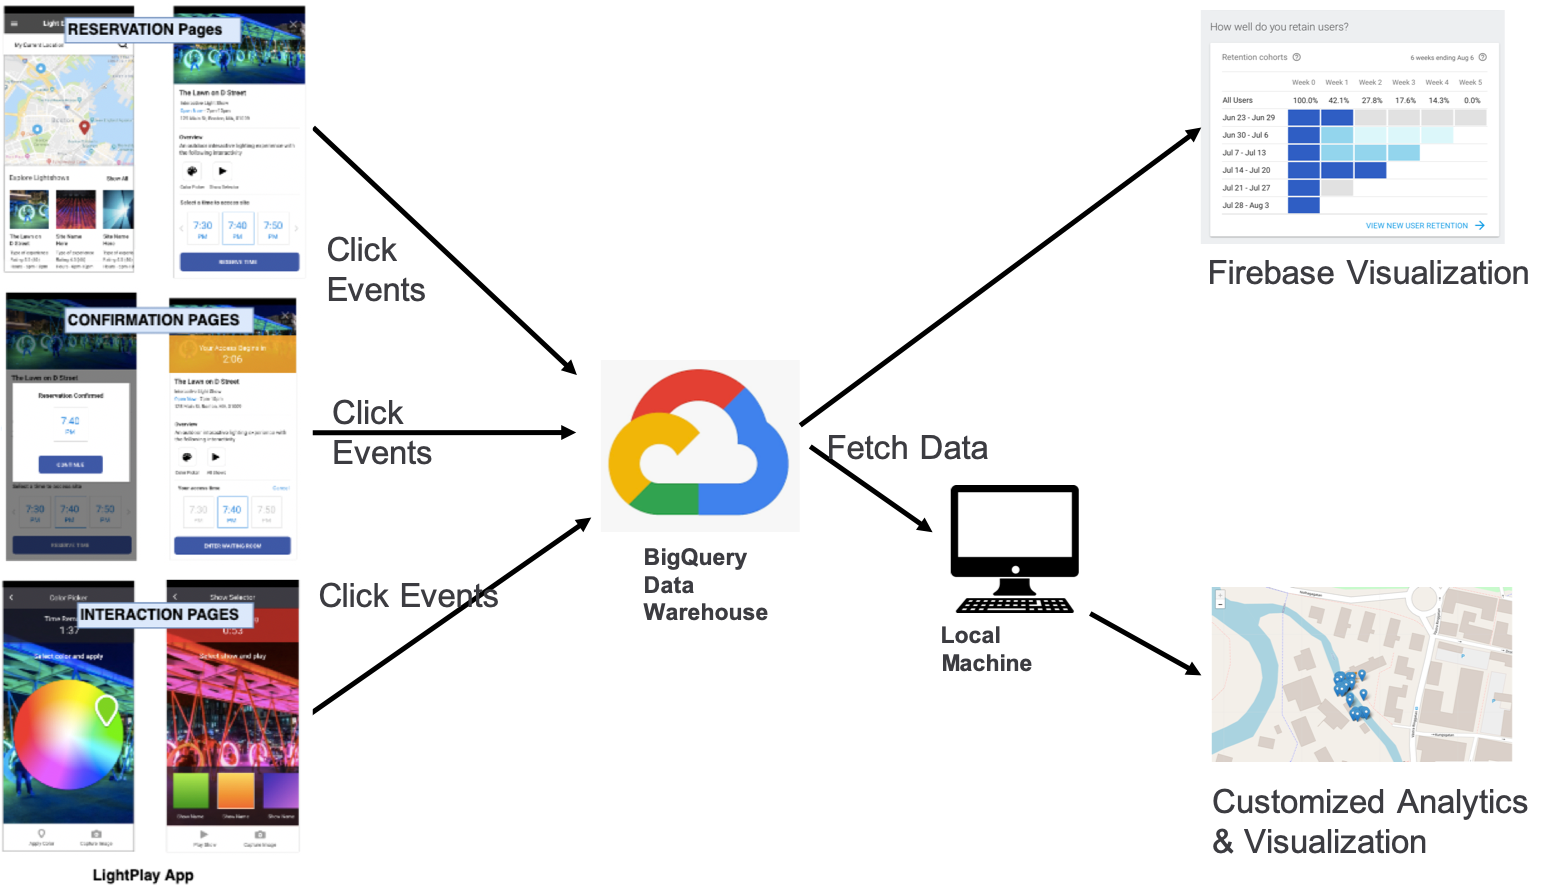

In [27]:
Image(filename='p3-demo/Picture1.png') 

# Fetch Data

In [28]:
key_path = "/Users/yizhouzang/Documents/Philips/Light_Play_App_Data_Analytics/lightplay_service_account_key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=key_path
endpoint = "https://bigquery.googleapis.com"

In [29]:
credentials = service_account.Credentials.from_service_account_file(key_path)
scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])


projectId = "interactlightplay"
datasetId = "analytics_202431492"

url = endpoint + "/bigquery/v2/projects/%s/datasets/%s/tables/" %(projectId,datasetId)

response = requests.get(url)
response.content.decode('utf-8')

'{\n  "error": {\n    "code": 401,\n    "message": "Request is missing required authentication credential. Expected OAuth 2 access token, login cookie or other valid authentication credential. See https://developers.google.com/identity/sign-in/web/devconsole-project.",\n    "errors": [\n      {\n        "message": "Login Required.",\n        "domain": "global",\n        "reason": "required",\n        "location": "Authorization",\n        "locationType": "header"\n      }\n    ],\n    "status": "UNAUTHENTICATED"\n  }\n}\n'

In [30]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    blob.download_to_filename(destination_file_name)

    print('Blob {} downloaded to {}.'.format(
        source_blob_name,
        destination_file_name))

In [136]:

client = bq.Client()

project = "interactlightplay"
dataset_id = "analytics_202431492"

# start = datetime.datetime.strptime('2019-07-09', '%Y-%m-%d')
latest = sorted(glob.glob('app_data/*.csv'))[-1][-12:-4]
latest = datetime.datetime.strptime(latest, '%Y%m%d')
start = latest + datetime.timedelta(days=1)

end = datetime.datetime.today()
step = datetime.timedelta(days=1)
while start <= end:
    date = start.strftime('%Y%m%d')
    table_id = "events_"+date

    destination_uri = "gs://{}/{}".format("exported_bigquery_test", date+".csv")
    dataset_ref = client.dataset(dataset_id, project=project)
    table_ref = dataset_ref.table(table_id)

    ejc = bq.ExtractJobConfig()
    ejc.destination_format='NEWLINE_DELIMITED_JSON'
    
    try:
        extract_job = client.extract_table(
            table_ref,
            destination_uri,
            # Location must match that of the source table.
            location="US",
            job_config=ejc
        )  # API request
        extract_job.result()  # Waits for job to complete.

        print(
            "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
        )

        download_blob("exported_bigquery_test", date+".csv","app_data/" + date + ".csv")   
    except:
        print("no data for "+table_id)
    start += step




Exported interactlightplay:analytics_202431492.events_20191015 to gs://exported_bigquery_test/20191015.csv
Blob 20191015.csv downloaded to app_data/20191015.csv.
no data for events_20191016


# Load Data

In [137]:
DIR = "app_data"

data = []
for filename in glob.glob(os.path.join(DIR,'*.csv')):
    with open(filename,"r") as f:
        for line in f:            
            try:
                data.append(json.loads(line))
            except:
                print("error")

data_with_userid = [x for x in data if 'user_id' in x.keys()]
len(data_with_userid)
alingsas_data = [x for x in data_with_userid if x['geo']['country']=="Sweden" and x["event_name"].startswith("click")]
len(alingsas_data)
data_with_userid = alingsas_data


In [185]:
data_with_userid[0]

{'event_date': '20191006',
 'event_timestamp': '1570384941283000',
 'event_name': 'click_exploresite',
 'event_params': [{'key': 'page', 'value': {'string_value': 'Light play'}},
  {'key': 'ga_session_id', 'value': {'int_value': '1570384928'}},
  {'key': 'firebase_error', 'value': {'int_value': '18'}},
  {'key': 'firebase_screen_class', 'value': {'string_value': 'HomeVC'}},
  {'key': 'user',
   'value': {'string_value': '98B7B778-4309-4253-B5BD-860445E1CFE2'}},
  {'key': 'engaged_session_event', 'value': {'int_value': '1'}},
  {'key': 'error_value', 'value': {'string_value': 'value'}},
  {'key': 'firebase_event_origin', 'value': {'string_value': 'app'}},
  {'key': 'ga_session_number', 'value': {'int_value': '1'}},
  {'key': 'firebase_screen_id',
   'value': {'int_value': '1798505812129145622'}}],
 'event_bundle_sequence_id': '3',
 'event_server_timestamp_offset': '202384',
 'user_id': '98B7B778-4309-4253-B5BD-860445E1CFE2',
 'user_pseudo_id': '03608FAF046B412AA79A5F572F73A2E3',
 'user_

# DEVICES

In [181]:
data = [x for x in data_with_userid if x["event_date"] in ["20191014"]]
devices =[]
for x in data:
    try:
       devices.append(x['device']['mobile_model_name'])
    except:
        print(x["event_name"])

In [182]:
list(unique(devices))

['A6013', 'H8266', 'SM-G950F', 'iPhone 7', 'iPhone 8', 'iPhone XS']

In [183]:
len(unique(devices))

6

In [ ]:
len([x for x in ])

# Pages Visited

In [138]:
events_stats = {}
for x in data_with_userid:
    if (x["event_name"] in events_stats):
        events_stats[x["event_name"]].append(x)
    else:
        events_stats[x["event_name"]] = [x]
# for k,v in events_stats.items():
#     print(k+":"+str(len(v)))

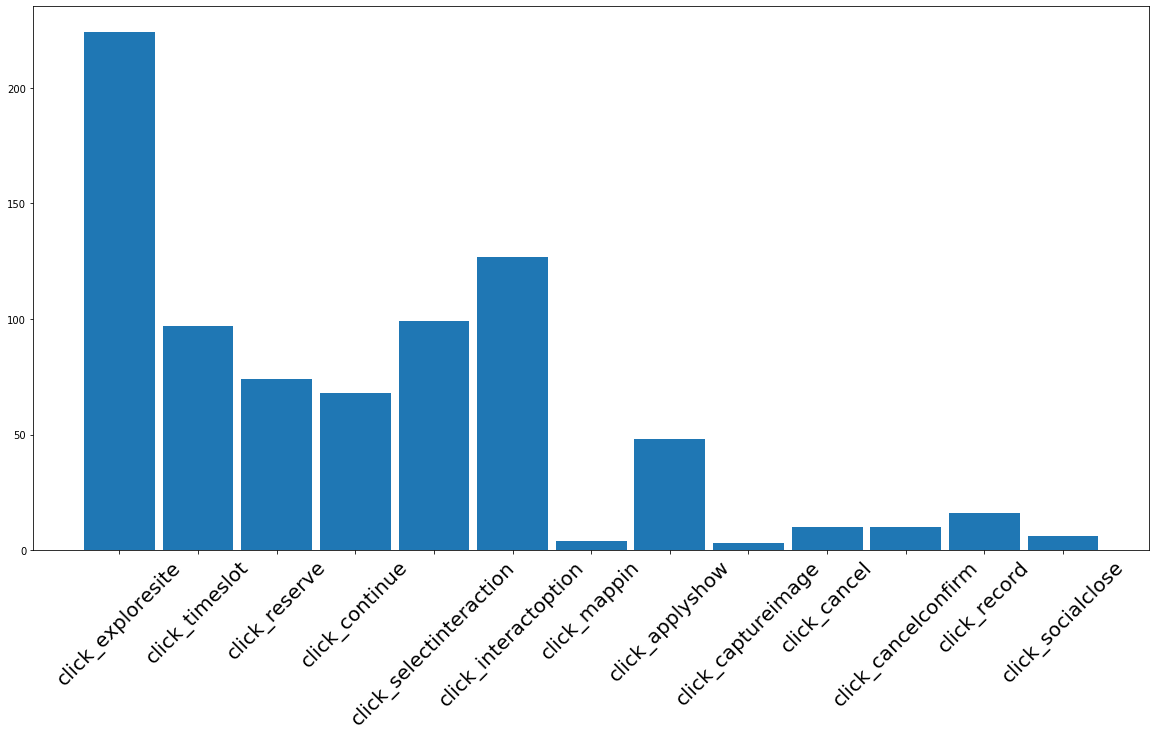

In [139]:

x = list(range(1,len(events_stats.keys())+1))
y = list([len(e) for e in events_stats.values()])
labels = events_stats.keys()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels,rotation=45)
ax.set_xticklabels(labels,fontsize=20)

ax.bar(x, y, width=0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# amount spend on each page

In [140]:
sorted_data_with_userid =  sorted(data_with_userid, key = lambda i: i['event_timestamp'])

In [141]:


time_spent_stats = {}
current_ga_session = ''
current_event_name = ''
current_timestamp = None
for s in sorted_data_with_userid:
    for kv in s["event_params"]:
        if kv["key"] != "ga_session_id": continue 
        if current_ga_session=='':
            current_ga_session = kv["value"]["int_value"]
            current_event_name = s["event_name"]
            current_timestamp = pd.to_datetime(int(s["event_timestamp"]), unit='us')
            break
        elif current_ga_session != kv["value"]["int_value"]:
            current_ga_session = kv["value"]["int_value"]
            current_event_name = s["event_name"]
            current_timestamp = pd.to_datetime(int(s["event_timestamp"]), unit='us')
            break
        elif current_ga_session == kv["value"]["int_value"]:
            t = pd.to_datetime(int(s["event_timestamp"]), unit='us')
            if s["event_name"] not in time_spent_stats:
                time_spent_stats[s["event_name"]] = (t - current_timestamp).total_seconds()
            else:
                time_spent_stats[s["event_name"]] = time_spent_stats[s["event_name"]] + (t - current_timestamp).total_seconds() 
            current_event_name = s["event_name"]
            current_timestamp = pd.to_datetime(int(s["event_timestamp"]), unit='us')
            break
            

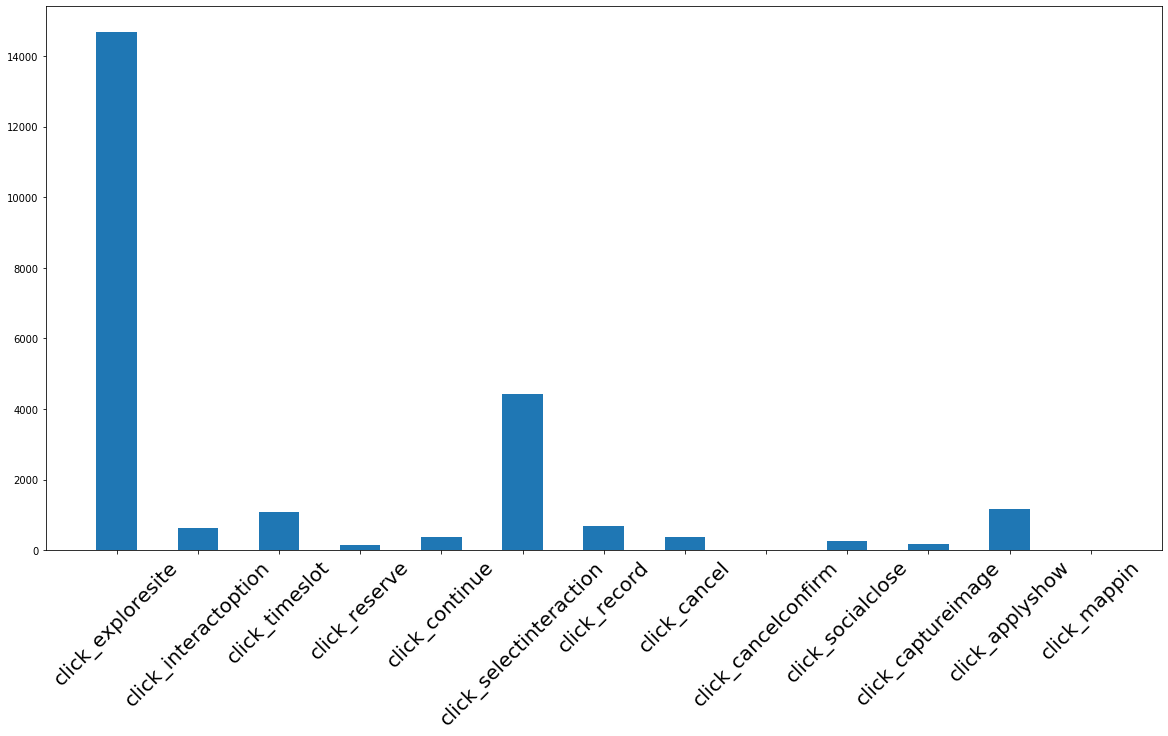

In [142]:
x = list(range(1,len(time_spent_stats.keys())+1))
y = list(time_spent_stats.values())
labels = time_spent_stats.keys()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels, rotation=45)
ax.set_xticklabels(labels, fontsize=20)

ax.bar(x, y, width=0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# Total number of unique AppIDs

In [143]:
users = [x["user_id"] for x in data_with_userid]
unique_users = unique(users)
len(unique_users)


75

# Number of users over time

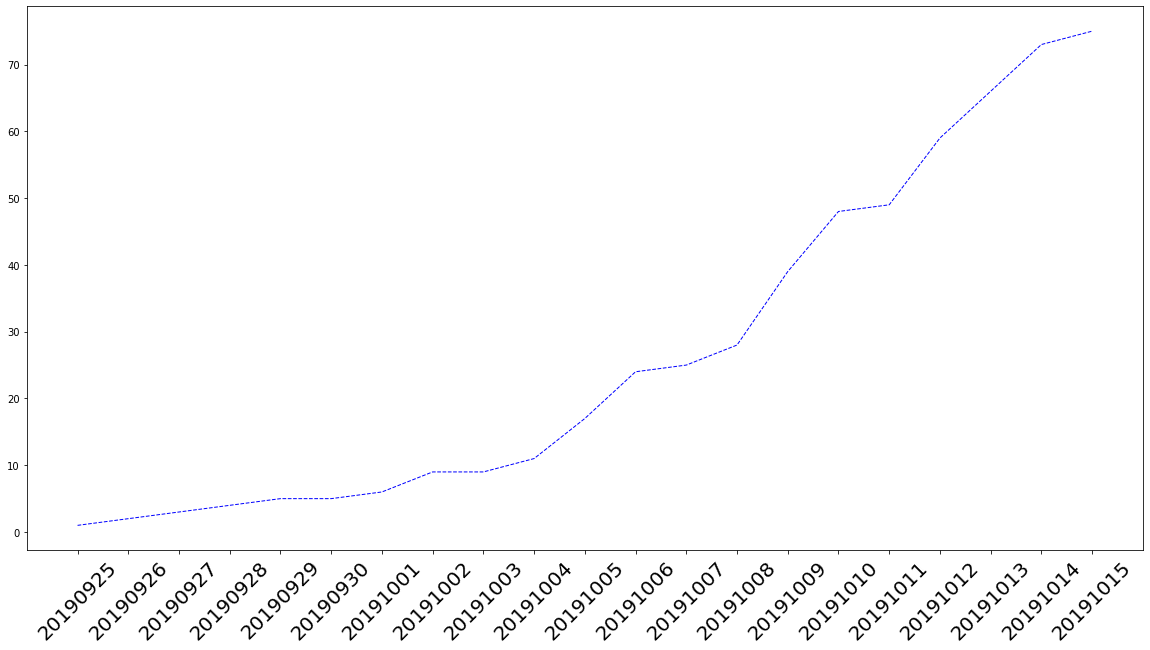

In [144]:
res = {}
days = sorted(unique([x["event_date"] for x in data_with_userid]))

for d in days:
    res[d] = []
    for e in data_with_userid:
        if e["event_date"] > d:
            continue
        else:
            res[d].append(e["user_id"])
for k,v in res.items():
    num = len(unique(v))
    res[k] = num

x = list(range(1,len(res.keys())+1))
y = list(res.values())
labels = res.keys()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels, rotation=45)
ax.set_xticklabels(labels, fontsize=20)

# ax.bar(x, y, width=0.9)
plt.plot(x,y,"b--",linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# Total number of Interactions

In [145]:
interactions = [x for x in data_with_userid if x["event_name"]=="click_applycolor" or x["event_name"]=="click_applyshow"]
len(interactions)

48

# Number of Interactions in each day 

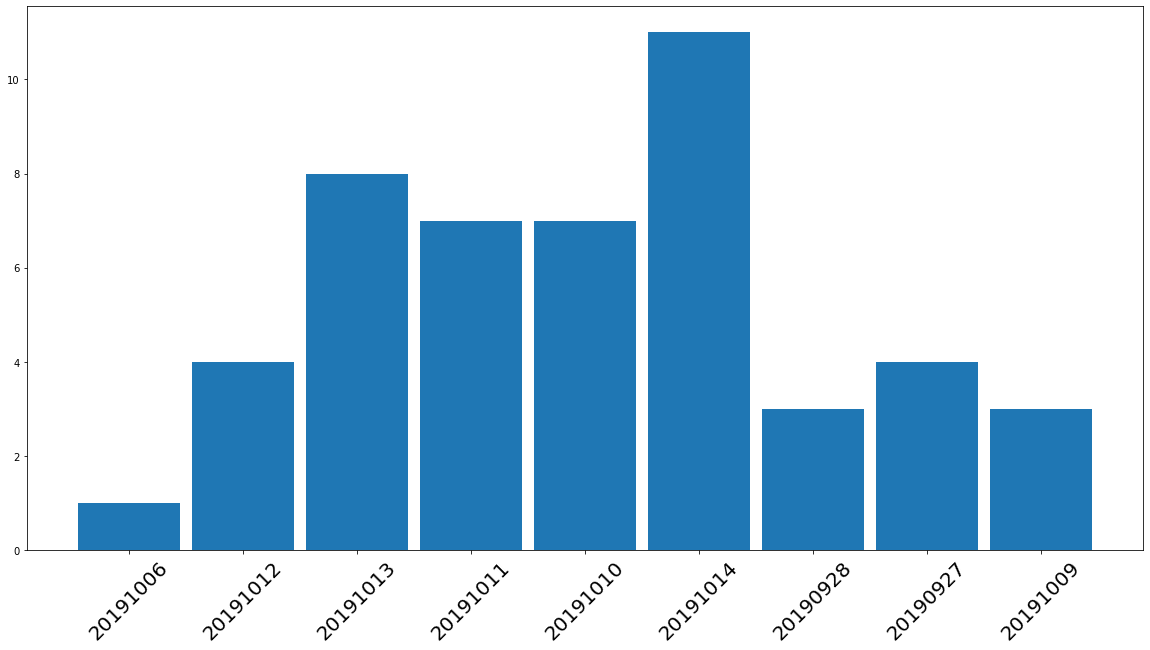

In [146]:
num_of_Interactions = {}
for e in interactions:
    if e["event_date"] in num_of_Interactions.keys():
        num_of_Interactions[e["event_date"]] = num_of_Interactions[e["event_date"]] + 1
    else:
        num_of_Interactions[e["event_date"]] = 1
    
x = list(range(1,len(num_of_Interactions.keys())+1))
y = list(num_of_Interactions.values())
labels = num_of_Interactions.keys()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels, rotation=45)
ax.set_xticklabels(labels, fontsize=20)

ax.bar(x, y, width=0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

In [ ]:
matrix usage

# Distribution of location of Interactions

In [184]:
interactions = [x for x in data_with_userid if x["event_name"]=="click_applycolor" or x["event_name"]=="click_applyshow"]
interactions_coords = get_coords(interactions)
m_interaction = folium.Map(location=[57.9312311,12.5282228], zoom_start=150)
[folium.Marker(interactions_coords[i],
                color='#0080bb', fill_color='#0080bb').add_to(m_interaction) 
for i in range(len(interactions_coords))]
m_interaction

# Total number of reservations

In [148]:
reservations = [x for x in data_with_userid if x["event_name"]=="click_reserve"]
len(reservations)

74

# Number of reservations in each day

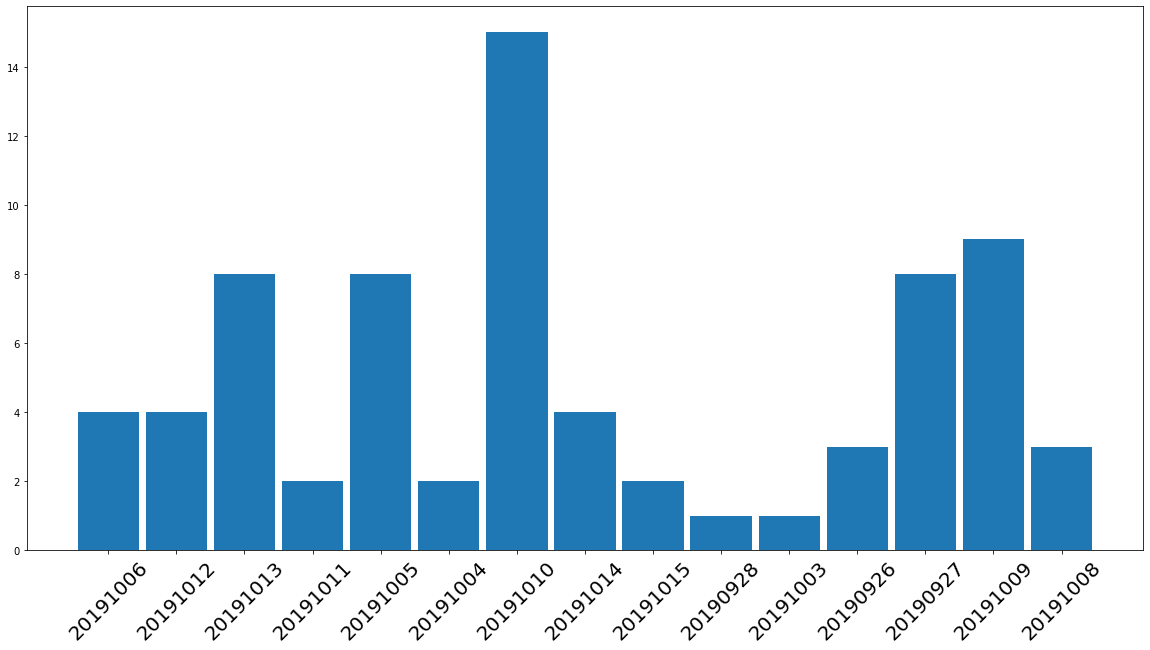

In [149]:
num_of_reservations = {}
for e in reservations:
    if e["event_date"] in num_of_reservations.keys():
        num_of_reservations[e["event_date"]] = num_of_reservations[e["event_date"]] + 1
    else:
        num_of_reservations[e["event_date"]] = 1
    
x = list(range(1,len(num_of_reservations.keys())+1))
y = list(num_of_reservations.values())
labels = num_of_reservations.keys()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels, rotation=45)
ax.set_xticklabels(labels, fontsize=20)

ax.bar(x, y, width=0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# Distribution of location of reservations

In [150]:
reservations = [x for x in data_with_userid if x["event_name"]=="click_reserve"]
reservations_coords = get_coords(reservations)
m_reservation = folium.Map(location=[57.9312311,12.5282228], zoom_start=15)
[folium.Marker(reservations_coords[i],
                color='#0080bb', fill_color='#0080bb').add_to(m_reservation) 
for i in range(len(reservations_coords))]
m_reservation

# What are the main flows users are following?

In [151]:
data_by_session = {}
curr_session = None
for d in data_with_userid:
    if curr_session == None:
        curr_session = get_session_id(d)
        data_by_session[curr_session] = [d]
        continue
    if curr_session == get_session_id(d):
        data_by_session[curr_session].append(d)
    else:
        curr_session = get_session_id(d)
        data_by_session[curr_session] = [d]
        
        
        

In [152]:
flows = {}
for k,v in data_by_session.items():
    alist = [x["event_name"] for x in v]
    ordered_subset= get_ordered_subset(alist)
    for x in ordered_subset:
        key = list_to_key(x)
        keys= flows.keys()
        if key not in keys:
            flows[key] = 1
        else:
            flows[key] = flows[key]+1

            
    

In [153]:
maxnumlist, res = get_most_common_sequences(10,2,flows) 

In [154]:
res

['click_exploresite-->click_exploresite',
 'click_exploresite-->click_timeslot',
 'click_exploresite-->click_timeslot-->click_reserve',
 'click_exploresite-->click_timeslot-->click_reserve-->click_continue',
 'click_interactoption-->click_interactoption-->click_interactoption',
 'click_reserve-->click_continue',
 'click_reserve-->click_continue-->click_selectinteraction',
 'click_timeslot-->click_reserve-->click_continue',
 'click_interactoption-->click_interactoption',
 'click_timeslot-->click_reserve']

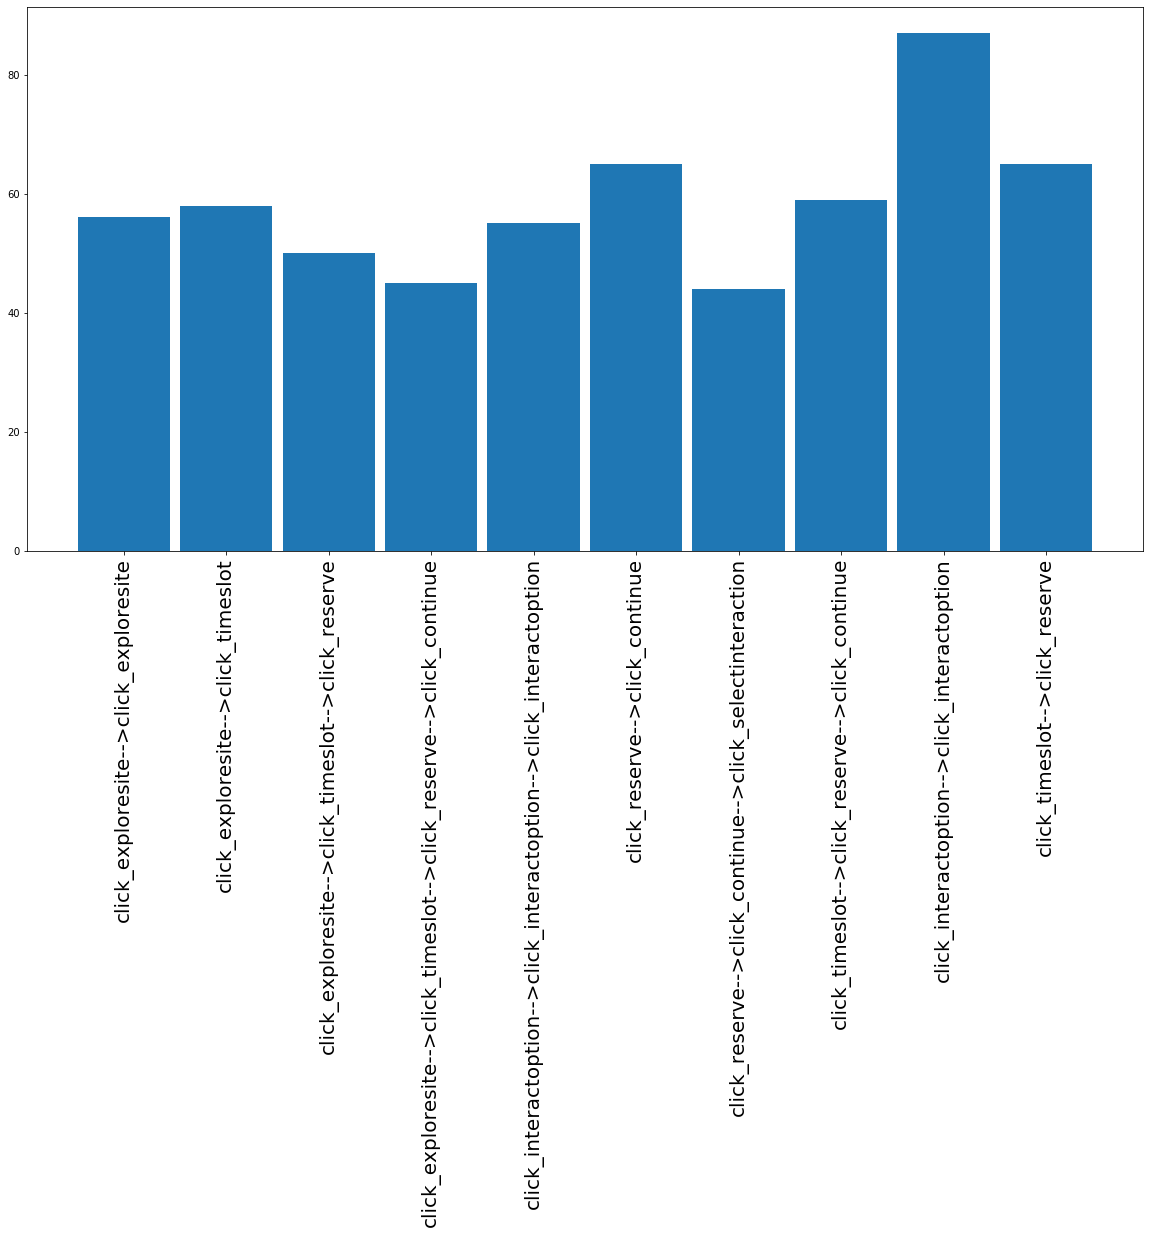

In [155]:
x = list(range(1,len(res)+1))
y = list(maxnumlist)
labels = res

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(labels, rotation=90)
ax.set_xticklabels(labels, fontsize=20)

ax.bar(x, y, width=0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# Reservations VS Interactions

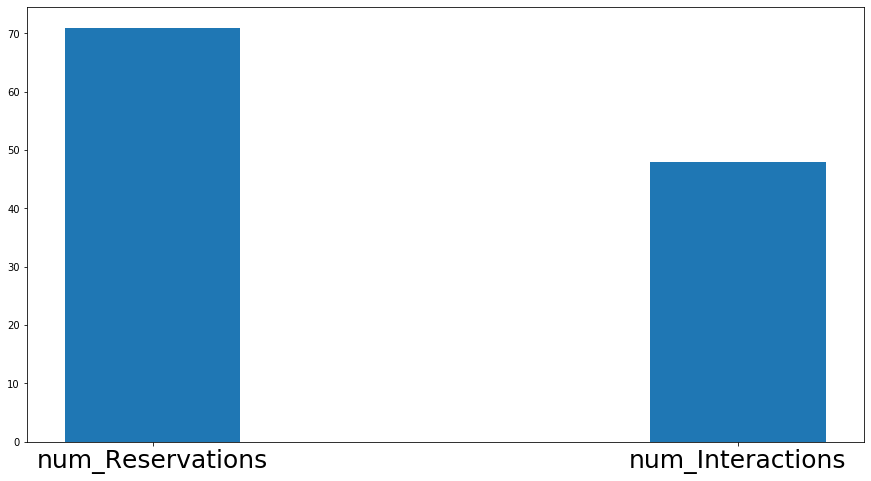

In [156]:
num_Reservations = 0
num_Interactions = 0
num_cancel_reserve = 0
for k,v in data_by_session.items():
    events = [x["event_name"] for x in v]
    num_Reservations = num_Reservations + events.count("click_reserve")
    num_Interactions = num_Interactions+ events.count("click_applycolor") + events.count("click_applyshow")
    num_cancel_reserve = num_cancel_reserve+ events.count("click_cancel")
x = list(range(1,3))
y = list([num_Reservations,num_Interactions])
labels = ["num_Reservations","num_Interactions"]

fig, ax = plt.subplots(figsize=(15,8))
# ax.set_xticklabels(columns, rotation=90)
ax.set_xticklabels(labels, fontsize=25)

ax.bar(x, y, width=0.3)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()
        

# Reservations VS Interactions VS Sharing

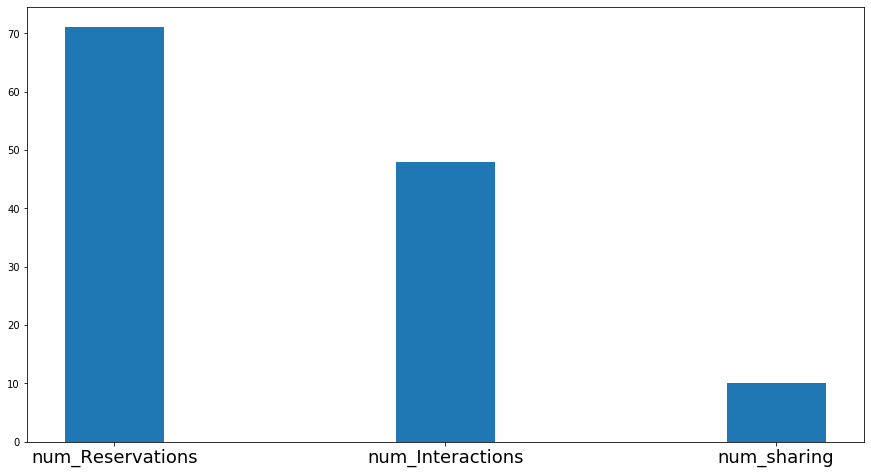

In [157]:
num_Reservations = 0
num_Interactions = 0
num_sharing = 0
for k,v in data_by_session.items():
    events = [x["event_name"] for x in v]
    num_Reservations = num_Reservations + events.count("click_reserve")
    num_Interactions = num_Interactions+ events.count("click_applycolor") + events.count("click_applyshow")
    num_sharing = num_cancel_reserve+ events.count("click_socialshare")
x = list(range(1,4))
y = list([num_Reservations,num_Interactions,num_sharing])
labels = ["num_Reservations","num_Interactions","num_sharing"]

fig, ax = plt.subplots(figsize=(15,8))
# ax.set_xticklabels(columns, rotation=90)
ax.set_xticklabels(labels, fontsize=18)

ax.bar(x, y, width=0.3)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()

# How often are all the slots booked vs each site

In [158]:
def get_timeslot(event):
    res = None
    for x in event["event_params"]:
        if x["key"] == 'value':
            res = x["value"]["string_value"]
            break
    return res
timeslot_events = [x for x in data_with_userid if x["event_name"]=="click_timeslot"]
timeslots = [get_timeslot(x) for x in timeslot_events]
timeslots_stats = {}
for k in unique(timeslots):
    timeslots_stats[k] = timeslots.count(k)

In [159]:
import operator
top_timeslots_stats = dict(sorted(timeslots_stats.items(), key=operator.itemgetter(1), reverse=True)[:10])

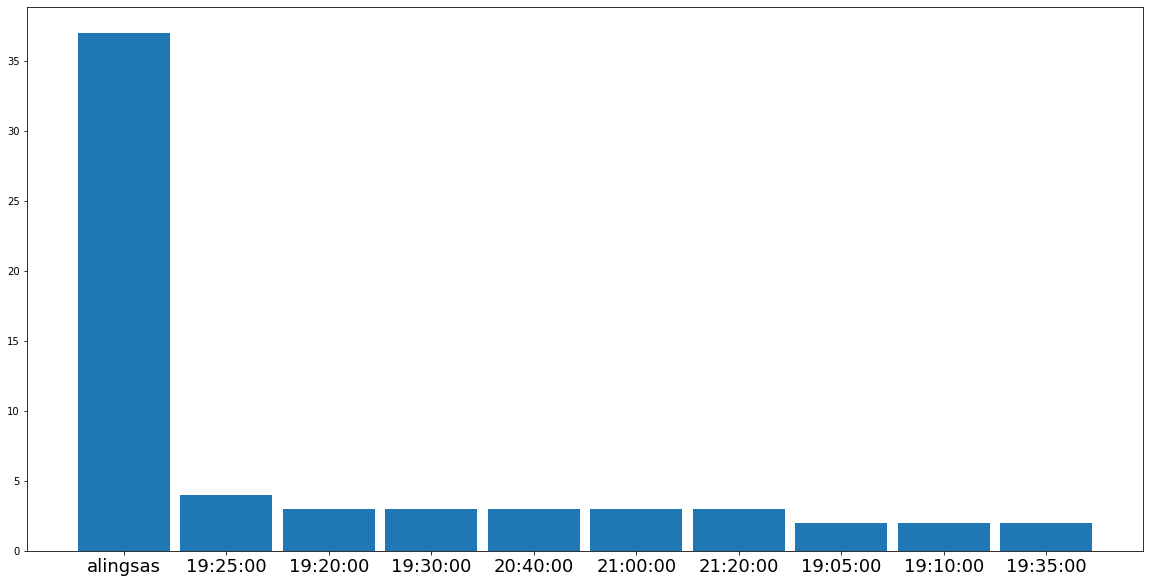

In [160]:
x = list(range(1,len(top_timeslots_stats.keys())+1))
y = list(top_timeslots_stats.values())
labels = top_timeslots_stats.keys()

fig, ax = plt.subplots(figsize=(20,10))
# ax.set_xticklabels(columns, rotation=90)
ax.set_xticklabels(labels, fontsize=18)

ax.bar(x, y, width=0.9)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.show()